In [1]:
import scipy
import scipy.sparse as sp
import numpy as np
import pandas as pd
import plotly.plotly as py
from string import maketrans, punctuation
import random
from time import time
import re

#import visplots

from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################

from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from scipy.stats.distributions import randint
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import normalize, Normalizer
#from sklearn.pipeline import Pipeline, make_pipeline

import nltk
from nltk.corpus import stopwords


init_notebook_mode()
%matplotlib inline 
print ("Required Libraries loaded.")

Required Libraries loaded.


In [2]:
# Import the data and explore the first few rows

inhibitor  = pd.read_csv("C:\EPC_Data\TREC_BROKEN\No_Mh_Tag/protonPumpInhibitors_no_mh.csv", sep=",")#, index_col = "PMID")
header = inhibitor.columns.values
inhibitor.head()

,PMID,Label,TIABSMh
0,10146883,0,Omeprazole: a pharmacoeconomic evaluation of i...
1,10533944,0,Helicobacter treatment with quadruple therapy ...
2,10540041,0,Review article: nonsteroidal antiinflammatory ...
3,10540046,0,Helicobacter pylori treatment instead of maint...
4,10547167,0,Lack of effect of treatment for Helicobacter p...


In [3]:
seed = 29
# shuffle dataset and split to train and test
x = shuffle(inhibitor, random_state = seed)
x.head()

,PMID,Label,TIABSMh
142,10989974,0,New treatment for Barrett's oesophagus.Barrett...
19,10594400,0,Omeprazole clarithromycin and furazolidone for...
542,8047832,0,Longterm consequences with regard to clinical ...
773,12680476,1,Pharmacogenetics of the proton pump inhibitors...
1014,8959519,0,Significant increase in eradication rates of H...


In [4]:
x.TIABSMh =  x.TIABSMh.str.replace(r'[^a-zA-Z\s]',' ')
Test_Size = 0.25

#split to test and train
x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = 37)

In [5]:
# Print the 1st row and 1st column of npArray
print (x_train.shape)
print (x_test.shape)

yFreq = scipy.stats.itemfreq(x.Label)
print("Overall class distribution: \n", yFreq)

# Print the y frequencies
yFreq = scipy.stats.itemfreq(y_train)
print("Train set distribution: \n", yFreq)

yFreq = scipy.stats.itemfreq(y_test)
print("\nTest set distribution: \n", yFreq)

(985L,)
(329L,)
('Overall class distribution: \n', array([[   0, 1260],
       [   1,   54]], dtype=int64))
('Train set distribution: \n', array([[  0, 946],
       [  1,  39]], dtype=int64))
('\nTest set distribution: \n', array([[  0, 314],
       [  1,  15]], dtype=int64))


In [6]:
# preprocess data
def binvec(xtr, xte):
    print("Extracting features from the dataset using a sparse vectorizer")
    t0 = time()
    bin_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.8, min_df = 2, binary = True, 
                                     use_idf = False, norm = None)
    xtr = bin_vectorizer.fit_transform(xtr)
    xte = bin_vectorizer.transform(xte)
    print("done in %fs" % (time() - t0))
    return xtr, xte

def tfidfvec(xtr, xte):
    print("Extracting features from the dataset using a sparse vectorizer")
    t0 = time()
    tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.8, min_df = 2, binary = False, 
                                       use_idf = True, smooth_idf = True, norm = 'l2')
    xtr = tfidf_vectorizer.fit_transform(xtr)
    xte = tfidf_vectorizer.transform(xte)
    print("done in %fs" % (time() - t0))
    return xtr, xte


def tfvec(xtr, xte):
    print("Extracting features from the dataset using a sparse vectorizer")
    t0 = time()
    tf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.8, min_df = 2, binary = False, 
                                    use_idf = False, smooth_idf = False, norm = 'l2')
    xtr = tf_vectorizer.fit_transform(xtr)
    xte = tf_vectorizer.transform(xte)
    print("done in %fs" % (time() - t0))
    return xtr, xte


bin_Xtrain, bin_Xtest = binvec(x_train, x_test)
tfidf_Xtrain, tfidf_Xtest = tfidfvec(x_train, x_test)
tf_Xtrain, tf_Xtest = tfvec(x_train, x_test)

print("n_samples: %d, n_features: %d" % bin_Xtrain.shape)
print("n_samples: %d, n_features: %d" % tfidf_Xtrain.shape)
print("n_samples: %d, n_features: %d" % tf_Xtrain.shape)
assert sp.issparse(bin_Xtrain)
assert sp.issparse(tfidf_Xtrain)
assert sp.issparse(tf_Xtrain)


print("n_samples: %d, n_features: %d" % bin_Xtest.shape)
print("n_samples: %d, n_features: %d" % tfidf_Xtest.shape)
print("n_samples: %d, n_features: %d" % tf_Xtest.shape)

Extracting features from the dataset using a sparse vectorizer
done in 0.405000s
Extracting features from the dataset using a sparse vectorizer
done in 0.359000s
Extracting features from the dataset using a sparse vectorizer
done in 0.343000s
n_samples: 985, n_features: 4778
n_samples: 985, n_features: 4778
n_samples: 985, n_features: 4778
n_samples: 329, n_features: 4778
n_samples: 329, n_features: 4778
n_samples: 329, n_features: 4778


In [7]:
def ch2(xtr, ytr, xte):
    ch = SelectKBest(chi2, k=4000)
    xtrain = ch.fit_transform(xtr, ytr)
    xtest = ch.transform(xte)
    return xtrain, xtest


bin_Xtrain, bin_Xtest = ch2(bin_Xtrain, y_train, bin_Xtest)
tfidf_Xtrain, tfidf_Xtest = ch2(tfidf_Xtrain, y_train, tfidf_Xtest)
tf_Xtrain, tf_Xtest = ch2(tf_Xtrain, y_train, tf_Xtest)

In [8]:
def weight(x):
    x = np.where(x==0, 1, 4)
    return x 

Training and test datasets created
SVM with Linear kernel C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.187s
test time:  0.047s
accuracy:   0.945
precision:  0.200
recall:     0.067
('Complexity: ', array([184,  39]))
*** AUC for ROC = 0.794

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.96      0.99      0.97       314
   Relevant       0.20      0.07      0.10        15

avg / total       0.92      0.95      0.93       329

confusion matrix:
[[310   4]
 [ 14   1]]
()
SVM with Linear kernel C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coe

C:\Users\raylite\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



train time: 0.734s
test time:  0.249s
accuracy:   0.046
precision:  0.046
recall:     1.000
('Complexity: ', array([946,  33]))
*** AUC for ROC = 0.879

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.00      0.00      0.00       314
   Relevant       0.05      1.00      0.09        15

avg / total       0.00      0.05      0.00       329

confusion matrix:
[[  0 314]
 [  0  15]]
()
SVM with Poly kernel C=100
________________________________________________________________________________
Training: 
SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.826s
test time:  0.281s
accuracy:   0.046
precision:  0.046
recall:     1.000
('Complexity: ', array([946,  39]))
*** AUC for ROC = 0.883

classification report:
             precision    recall  f1-sc

C:\Users\raylite\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



('Complexity: ', array([653,  39]))
*** AUC for ROC = 0.829

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.95      1.00      0.98       314
   Relevant       0.00      0.00      0.00        15

avg / total       0.91      0.95      0.93       329

confusion matrix:
[[314   0]
 [ 15   0]]
()
SVM with sigmoid kernel C=1
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.749s
test time:  0.281s
accuracy:   0.046
precision:  0.046
recall:     1.000
('Complexity: ', array([946,  37]))
*** AUC for ROC = 0.910

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.00      0.00      0.00       314
   Relevant       0.05

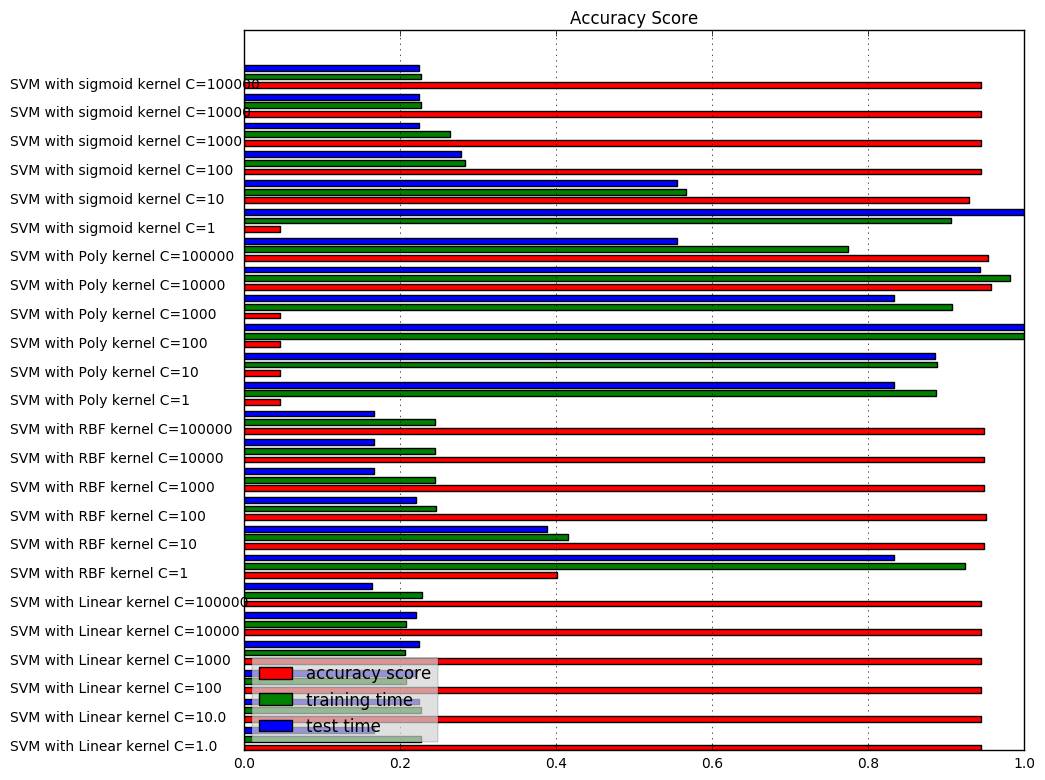

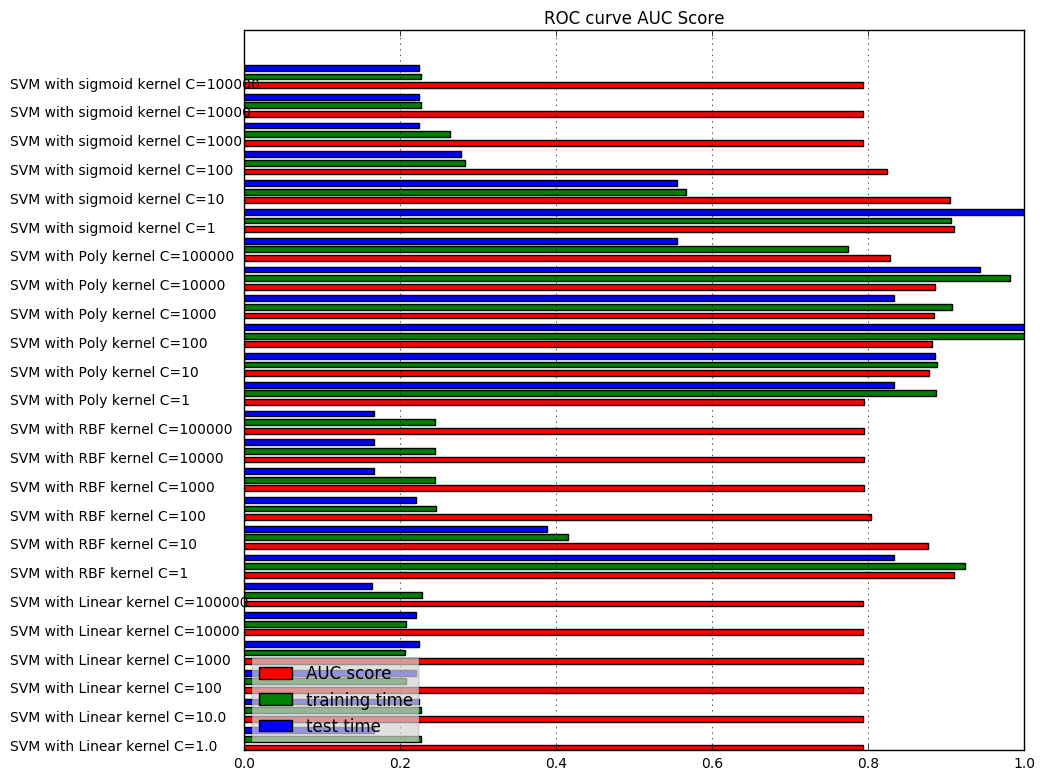

In [9]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True
RANDOM_STATE = 55

########


sw_train = weight(y_train)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(bin_clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(bin_clf)
    t0 = time()
    try:
        bin_clf.fit(bin_Xtrain, y_train, sample_weight = sw_train)#with weight
    except:
        bin_clf.fit(bin_Xtrain, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = bin_clf.predict(bin_Xtest)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(bin_clf, "decision_function"):
        y_score = np.array(bin_clf.decision_function(bin_Xtest))
    else:
        y_score = bin_clf.predict_proba(bin_Xtest)[:,1]
        
    if hasattr(bin_clf, "n_support_"):
        print ("Complexity: ", bin_clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(bin_clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10000"),
            (SVC(kernel="linear", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10000"),
            (SVC(kernel="rbf", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100000"),
            (SVC(kernel="poly", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1"),
            (SVC(kernel="poly", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10"),
            (SVC(kernel="poly", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100"),
            (SVC(kernel="poly", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1000"),
            (SVC(kernel="poly", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10000"),
            (SVC(kernel="poly", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100000"),
            (SVC(kernel="sigmoid", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1"),
            (SVC(kernel="sigmoid", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10"),
            (SVC(kernel="sigmoid", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100"),
            (SVC(kernel="sigmoid", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1000"),
            (SVC(kernel="sigmoid", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10000"),
            (SVC(kernel="sigmoid", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100000")            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))
    return results
    

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    
   
    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()
    
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

Training and test datasets created
SVM with Linear kernel C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.234s
test time:  0.078s
accuracy:   0.954
precision:  0.500
recall:     0.400
('Complexity: ', array([268,  39]))
*** AUC for ROC = 0.887

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.97      0.98      0.98       314
   Relevant       0.50      0.40      0.44        15

avg / total       0.95      0.95      0.95       329

confusion matrix:
[[308   6]
 [  9   6]]
()
SVM with Linear kernel C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coe

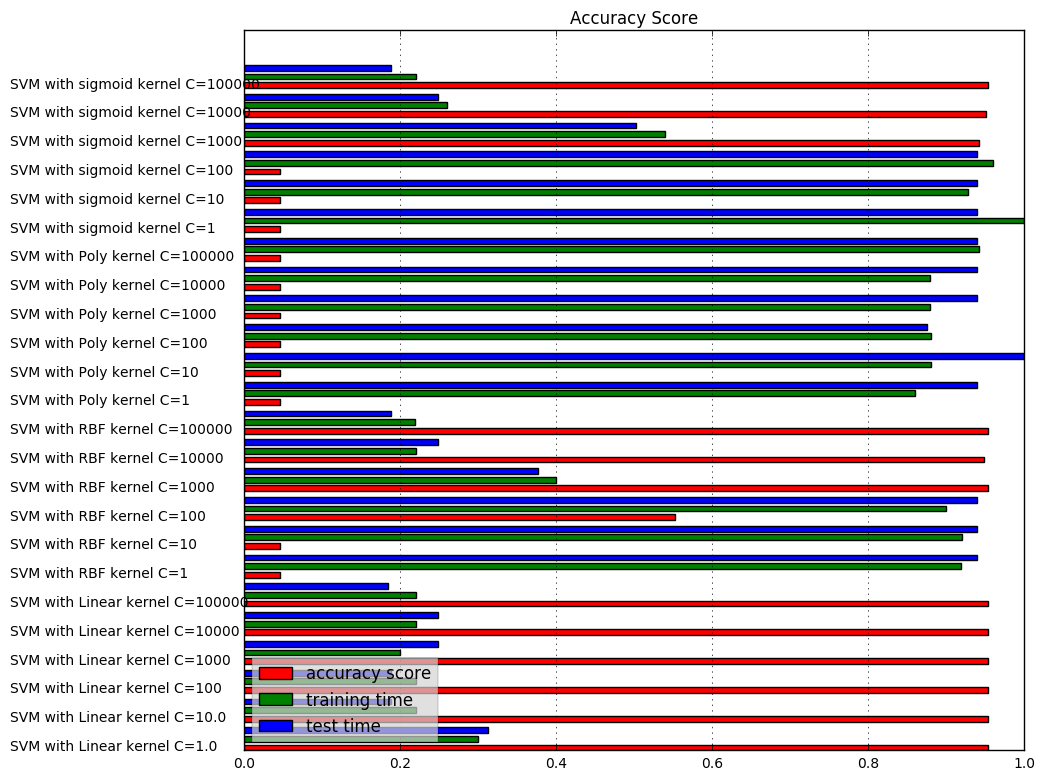

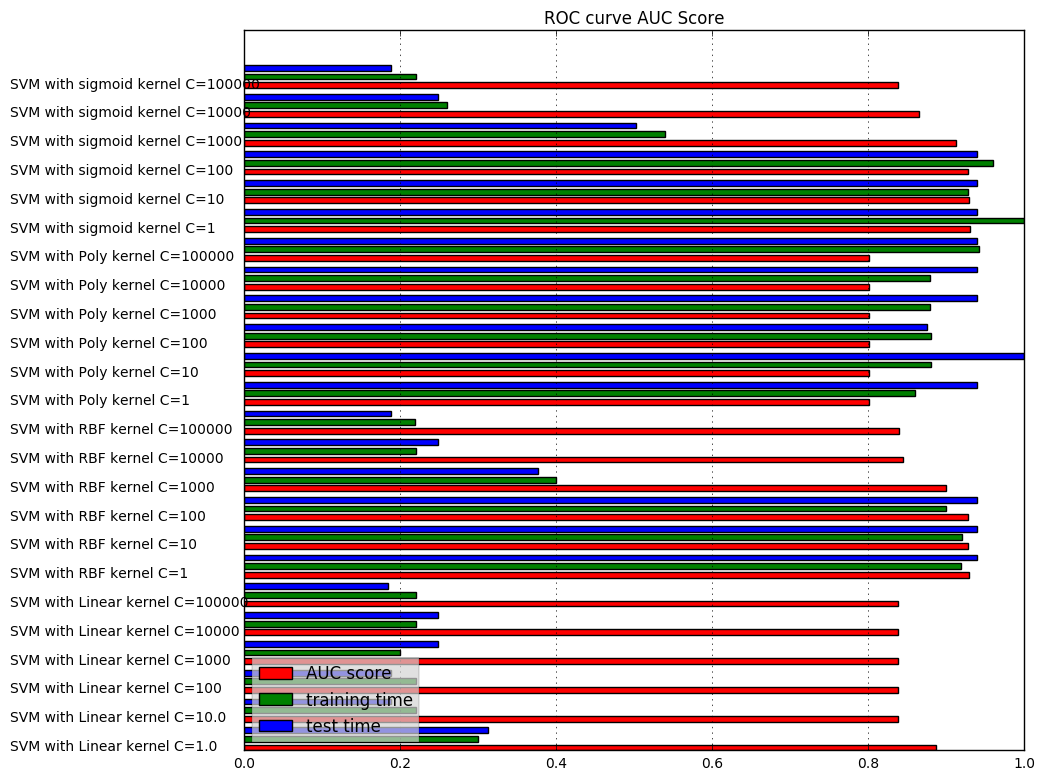

In [10]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True
RANDOM_STATE = 55

########


sw_train = weight(y_train)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(tfidf_clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(tfidf_clf)
    t0 = time()
    try:
        tfidf_clf.fit(tfidf_Xtrain, y_train, sample_weight = sw_train)#with weight
    except:
        tfidf_clf.fit(tfidf_Xtrain, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = tfidf_clf.predict(tfidf_Xtest)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(tfidf_clf, "decision_function"):
        y_score = np.array(tfidf_clf.decision_function(tfidf_Xtest))
    else:
        y_score = tfidf_clf.predict_proba(tfidf_Xtest)[:,1]
        
    if hasattr(tfidf_clf, "n_support_"):
        print ("Complexity: ", tfidf_clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(tfidf_clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10000"),
            (SVC(kernel="linear", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10000"),
            (SVC(kernel="rbf", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100000"),
            (SVC(kernel="poly", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1"),
            (SVC(kernel="poly", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10"),
            (SVC(kernel="poly", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100"),
            (SVC(kernel="poly", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1000"),
            (SVC(kernel="poly", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10000"),
            (SVC(kernel="poly", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100000"),
            (SVC(kernel="sigmoid", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1"),
            (SVC(kernel="sigmoid", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10"),
            (SVC(kernel="sigmoid", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100"),
            (SVC(kernel="sigmoid", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1000"),
            (SVC(kernel="sigmoid", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10000"),
            (SVC(kernel="sigmoid", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100000")            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))
    return results
    

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    
   
    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()
    
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

Training and test datasets created
SVM with Linear kernel C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 0.328s
test time:  0.093s
accuracy:   0.948
precision:  0.450
recall:     0.600
('Complexity: ', array([311,  38]))
*** AUC for ROC = 0.907

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.96      0.97       314
   Relevant       0.45      0.60      0.51        15

avg / total       0.96      0.95      0.95       329

confusion matrix:
[[303  11]
 [  6   9]]
()
SVM with Linear kernel C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coe

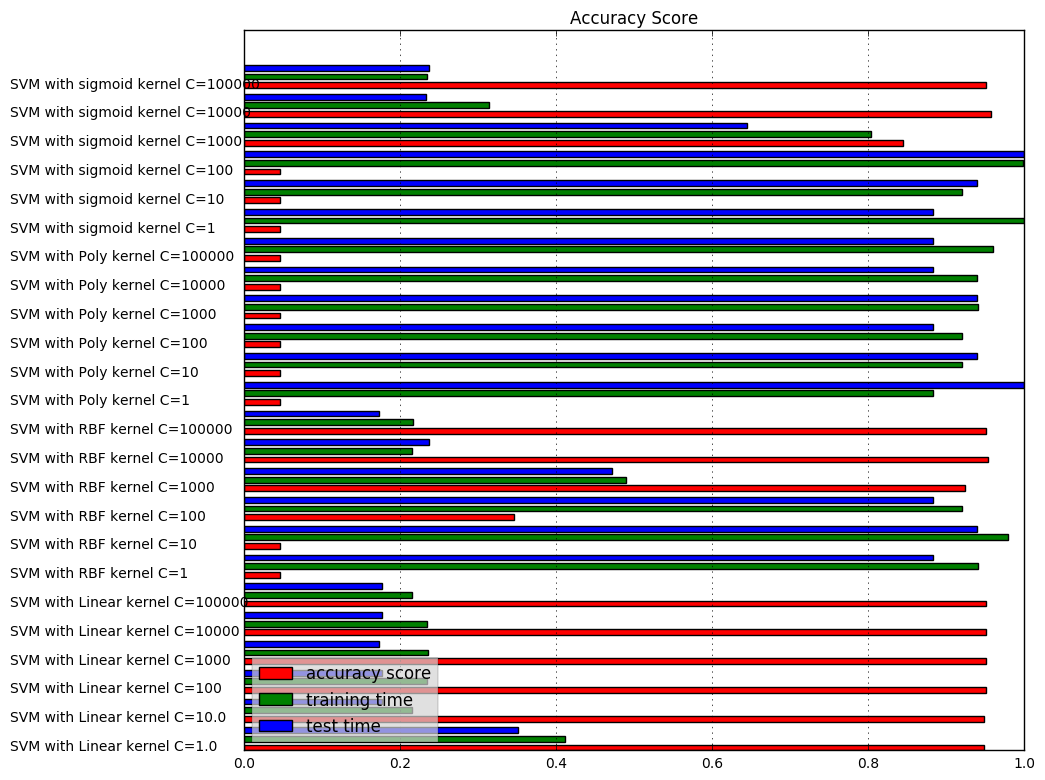

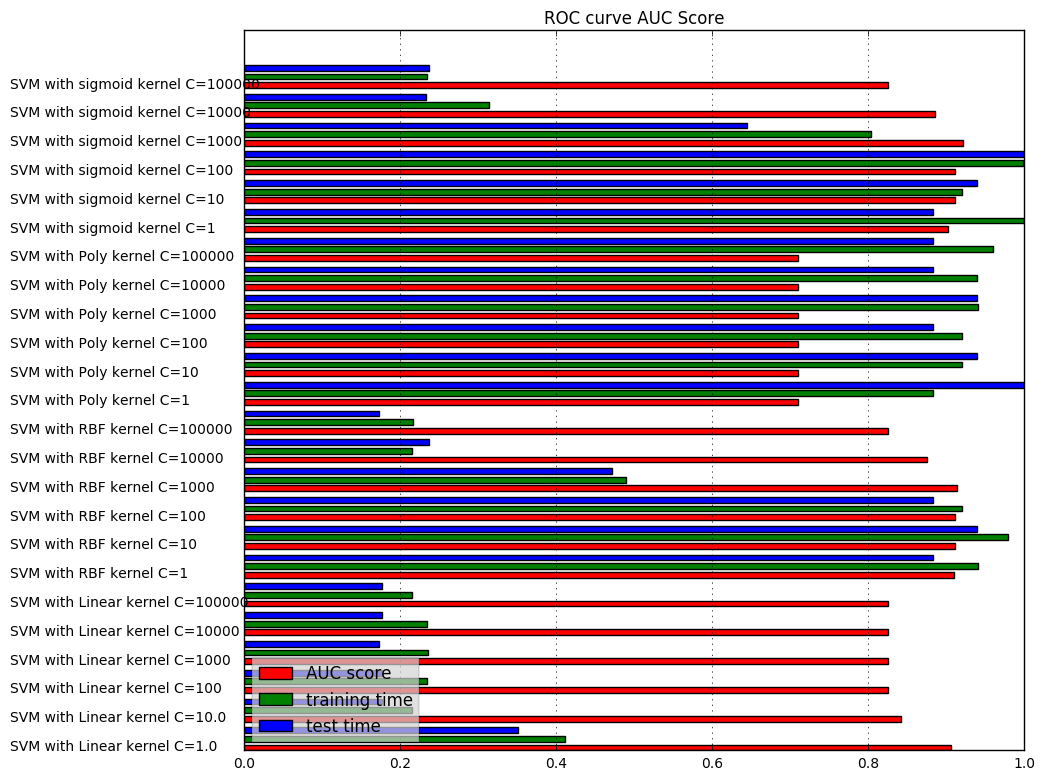

In [11]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html
#TF model
# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True
RANDOM_STATE = 55

########


sw_train = weight(y_train)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(tf_clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(tf_clf)
    t0 = time()
    try:
        tf_clf.fit(tf_Xtrain, y_train, sample_weight = sw_train)#with weight
    except:
        tf_clf.fit(tf_Xtrain, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = tf_clf.predict(tf_Xtest)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(tf_clf, "decision_function"):
        y_score = np.array(tf_clf.decision_function(tf_Xtest))
    else:
        y_score = tf_clf.predict_proba(tf_Xtest)[:,1]
        
    if hasattr(tf_clf, "n_support_"):
        print ("Complexity: ", tf_clf.n_support_)
    
    
    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(tf_clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=10000"),
            (SVC(kernel="linear", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Linear kernel C=100000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10000"),
            (SVC(kernel="rbf", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100000"),
            (SVC(kernel="poly", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1"),
            (SVC(kernel="poly", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10"),
            (SVC(kernel="poly", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100"),
            (SVC(kernel="poly", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=1000"),
            (SVC(kernel="poly", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=10000"),
            (SVC(kernel="poly", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with Poly kernel C=100000"),
            (SVC(kernel="sigmoid", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1"),
            (SVC(kernel="sigmoid", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10"),
            (SVC(kernel="sigmoid", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100"),
            (SVC(kernel="sigmoid", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=1000"),
            (SVC(kernel="sigmoid", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=10000"),
            (SVC(kernel="sigmoid", C=100000.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with sigmoid kernel C=100000")            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))
    return results
    

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    
   
    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()
    
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

In [12]:
#!pip install --upgrade version_information
#%reload_ext version_information
%load_ext version_information 
%version_information scipy, numpy, sklearn, pandas, scipy, nltk, matplotlib

Software,Version
Python,2.7.13 64bit [MSC v.1500 64 bit (AMD64)]
IPython,5.1.0
OS,Windows 7 6.1.7601 SP1
scipy,0.18.1
numpy,1.11.2
sklearn,0.18.1
pandas,0.18.1
scipy,0.18.1
nltk,3.2.1
matplotlib,1.5.3


In [13]:
##best BINARY configuration
clf = SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='rbf', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []


for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = binvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.678000s
Fitting for Seed = 35
('Support vectors: ', array([944,  33]))
[[168 148]
 [  3  10]]
Extracting features from the dataset using a sparse vectorizer
done in 0.577000s
Fitting for Seed = 71
('Support vectors: ', array([941,  41]))
[[119 200]
 [  0  10]]
Extracting features from the dataset using a sparse vectorizer
done in 0.593000s
Fitting for Seed = 21
('Support vectors: ', array([948,  34]))
[[ 93 219]
 [  0  17]]
Extracting features from the dataset using a sparse vectorizer
done in 0.593000s
Fitting for Seed = 61
('Support vectors: ', array([946,  36]))
[[170 144]
 [  1  14]]
Extracting features from the dataset using a sparse vectorizer
done in 0.562000s
Fitting for Seed = 55
('Support vectors: ', array([946,  35]))
[[180 134]
 [  1  14]]
SVM Cross validation results: 
Mean Precision: 0.07 +/- 0.02 
  Mean  Recall: 0.93 +/- 0.08
      Mean  F1: 0.14 +/- 0.03
Mean  Accuracy: 0.48 +/- 0.10
(' True Negat

In [19]:
clf = SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='sigmoid', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []


for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = binvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.639000s
Fitting for Seed = 35
('Support vectors: ', array([533,  37]))
[[295  21]
 [  6   7]]
Extracting features from the dataset using a sparse vectorizer
done in 0.530000s
Fitting for Seed = 71
('Support vectors: ', array([577,  42]))
[[294  25]
 [  5   5]]
Extracting features from the dataset using a sparse vectorizer
done in 0.530000s
Fitting for Seed = 21
('Support vectors: ', array([600,  37]))
[[283  29]
 [  2  15]]
Extracting features from the dataset using a sparse vectorizer
done in 0.546000s
Fitting for Seed = 61
('Support vectors: ', array([549,  38]))
[[297  17]
 [  7   8]]
Extracting features from the dataset using a sparse vectorizer
done in 0.531000s
Fitting for Seed = 55
('Support vectors: ', array([531,  36]))
[[293  21]
 [  9   6]]
SVM Cross validation results: 
Mean Precision: 0.26 +/- 0.06 
  Mean  Recall: 0.57 +/- 0.16
      Mean  F1: 0.35 +/- 0.09
Mean  Accuracy: 0.91 +/- 0.01
(' True Negat

In [15]:
##best TFIDF configuration
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='rbf', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []

for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = tfidfvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.593000s
Fitting for Seed = 35
('Support vectors: ', array([944,  35]))
[[231  85]
 [  3  10]]
Extracting features from the dataset using a sparse vectorizer
done in 0.593000s
Fitting for Seed = 71
('Support vectors: ', array([941,  38]))
[[185 134]
 [  0  10]]
Extracting features from the dataset using a sparse vectorizer
done in 0.577000s
Fitting for Seed = 21
('Support vectors: ', array([948,  32]))
[[178 134]
 [  0  17]]
Extracting features from the dataset using a sparse vectorizer
done in 0.593000s
Fitting for Seed = 61
('Support vectors: ', array([946,  35]))
[[215  99]
 [  4  11]]
Extracting features from the dataset using a sparse vectorizer
done in 0.546000s
Fitting for Seed = 55
('Support vectors: ', array([945,  33]))
[[209 105]
 [  4  11]]
SVM Cross validation results: 
Mean Precision: 0.10 +/- 0.01 
  Mean  Recall: 0.85 +/- 0.13
      Mean  F1: 0.17 +/- 0.02
Mean  Accuracy: 0.65 +/- 0.05
(' True Negat

In [16]:
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='sigmoid', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []

for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = tfidfvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.561000s
Fitting for Seed = 35
('Support vectors: ', array([944,  35]))
[[  0 316]
 [  0  13]]
Extracting features from the dataset using a sparse vectorizer
done in 0.531000s
Fitting for Seed = 71
('Support vectors: ', array([941,  38]))
[[  0 319]
 [  0  10]]
Extracting features from the dataset using a sparse vectorizer
done in 0.546000s
Fitting for Seed = 21
('Support vectors: ', array([948,  32]))
[[  0 312]
 [  0  17]]
Extracting features from the dataset using a sparse vectorizer
done in 0.580000s
Fitting for Seed = 61
('Support vectors: ', array([946,  35]))
[[  0 314]
 [  0  15]]
Extracting features from the dataset using a sparse vectorizer
done in 0.578000s
Fitting for Seed = 55
('Support vectors: ', array([946,  33]))
[[  1 313]
 [  0  15]]
SVM Cross validation results: 
Mean Precision: 0.04 +/- 0.01 
  Mean  Recall: 1.00 +/- 0.00
      Mean  F1: 0.08 +/- 0.01
Mean  Accuracy: 0.04 +/- 0.01
(' True Negat

In [17]:
##best TF configuration
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
          gamma='auto', kernel='sigmoid', max_iter=-1, probability=False, random_state=55, shrinking=True,
          tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []



for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x.TIABSMh, x.Label, test_size = Test_Size, random_state = seed)
    X_train, X_test = tfvec(x_train, x_test)
    X_train, X_test = ch2(X_train, y_train, X_test)
    w = weight(y_train)

    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)

    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)

    pred = clf.predict(X_test)

    s_vector = clf.n_support_
    print ("Support vectors: ", s_vector)            

    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])

    acc_s = metrics.accuracy_score(y_test, pred)
    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])      

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Extracting features from the dataset using a sparse vectorizer
done in 0.561000s
Fitting for Seed = 35
('Support vectors: ', array([944,  29]))
[[  3 313]
 [  0  13]]
Extracting features from the dataset using a sparse vectorizer
done in 0.686000s
Fitting for Seed = 71
('Support vectors: ', array([941,  31]))
[[  0 319]
 [  0  10]]
Extracting features from the dataset using a sparse vectorizer
done in 0.577000s
Fitting for Seed = 21
('Support vectors: ', array([948,  28]))
[[  0 312]
 [  0  17]]
Extracting features from the dataset using a sparse vectorizer
done in 0.548000s
Fitting for Seed = 61
('Support vectors: ', array([946,  25]))
[[  1 313]
 [  0  15]]
Extracting features from the dataset using a sparse vectorizer
done in 0.608000s
Fitting for Seed = 55
('Support vectors: ', array([946,  28]))
[[  6 308]
 [  0  15]]
SVM Cross validation results: 
Mean Precision: 0.04 +/- 0.01 
  Mean  Recall: 1.00 +/- 0.00
      Mean  F1: 0.08 +/- 0.01
Mean  Accuracy: 0.05 +/- 0.01
(' True Negat

In [18]:
##best WORD2VEC configuration